##### Figure S16: Vgsc-region FST between South American specimens in the top and bottom clusters of the Vgsc PCA

In [1]:
from collections import defaultdict
import dask.array as da
from matplotlib.gridspec import GridSpec
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.ticker as tkr
import matplotlib.transforms as transforms
import numpy as np
import pandas as pd

import allel
import itertools

import ingenos

In [2]:
base_path = "/overflow/dschridelab/users/rrlove/aedes/"
md_path = f"{base_path}metadata/"
results_path = f"{base_path}results/"
zarr_path = "/proj/dschridelab/rrlove/aedes/vcf/filtered_110122/"

##### read in data

In [3]:
def return_data(zarr_path, data_type, data_name):
    
    fetch_str = f"{data_type}/{data_name}" 
    
    return da.from_zarr(zarr_path, component=fetch_str)

In [4]:
chroms_dict = defaultdict(dict)

chroms = ["AaegL5_1", "AaegL5_2", "AaegL5_3"]

for chrom in chroms:
    
    temp_in_path = zarr_path + chrom

    chroms_dict[chrom]["pos"] = return_data(temp_in_path, "variants", "POS")
    chroms_dict[chrom]["chrom"] = return_data(temp_in_path, "variants", "CHROM")
    chroms_dict[chrom]["ref"] = return_data(temp_in_path, "variants", "REF")
    chroms_dict[chrom]["alt"] = return_data(temp_in_path, "variants", "ALT")
    chroms_dict[chrom]["ac"] = return_data(temp_in_path, "variants", "AC")
    chroms_dict[chrom]["qd"] = return_data(temp_in_path, "variants", "QD")
    chroms_dict[chrom]["mq"] = return_data(temp_in_path, "variants", "MQ")
    chroms_dict[chrom]["fs"] = return_data(temp_in_path, "variants", "FS")
    chroms_dict[chrom]["mqrs"] = return_data(temp_in_path, "variants", "MQRankSum")
    chroms_dict[chrom]["rprs"] = return_data(temp_in_path, "variants", "ReadPosRankSum")
    chroms_dict[chrom]["sor"] = return_data(temp_in_path, "variants", "SOR")
    chroms_dict[chrom]["is_snp"] = return_data(temp_in_path, "variants", "is_snp")
    chroms_dict[chrom]["numalt"] = return_data(temp_in_path, "variants", "numalt")
    chroms_dict[chrom]["filter_pass"] = return_data(temp_in_path, "variants", "FILTER_PASS")

    chroms_dict[chrom]["gt"] = return_data(temp_in_path, "calldata", "GT")
    chroms_dict[chrom]["gq"] = return_data(temp_in_path, "calldata", "GQ")
    chroms_dict[chrom]["ad"] = return_data(temp_in_path, "calldata", "AD")
    chroms_dict[chrom]["pl"] = return_data(temp_in_path, "calldata", "PL")
    chroms_dict[chrom]["dp"] = return_data(temp_in_path, "calldata", "DP")
    
    print(chrom, chroms_dict[chrom]["gt"].shape)
    
samples = da.from_zarr(temp_in_path, component="samples")

AaegL5_1 (18443972, 131, 2)
AaegL5_2 (32930875, 131, 2)
AaegL5_3 (27660249, 131, 2)


In [5]:
np.sum([chroms_dict[chrom]["gt"].shape[0] for chrom in chroms])

79035096

##### read in metadata

In [6]:
md = pd.read_table(
    md_path + "whole_sample_sorted_country.031522.csv", 
    sep="\t",)

md["locality"] = md["location"].str.split(": ", expand=True)[1]

md.head()

,sample_id,sample_short,location,sex,batch,sample_id_cat,country,locality
0,FEMALE_1-F1_CGCATGAT-TCAGGCTT_S1,FEMALE_1,Colombia: Rio Claro,F,1,FEMALE_1-F1_CGCATGAT-TCAGGCTT_S1,Colombia,Rio Claro
1,FEMALE_10-F10_GTGCCATA-ACTAGGAG_S2,FEMALE_10,Colombia: Rio Claro,F,1,FEMALE_10-F10_GTGCCATA-ACTAGGAG_S2,Colombia,Rio Claro
2,FEMALE_11-F11_CGTTGCAA-CGCTCTAT_S3,FEMALE_11,Colombia: Rio Claro,F,1,FEMALE_11-F11_CGTTGCAA-CGCTCTAT_S3,Colombia,Rio Claro
3,FEMALE_12-F12_TGAAGACG-TGGCATGT_S4,FEMALE_12,Colombia: Rio Claro,F,1,FEMALE_12-F12_TGAAGACG-TGGCATGT_S4,Colombia,Rio Claro
4,FEMALE_14-F14_ACGTTCAG-GCACAACT_S6,FEMALE_14,Colombia: Rio Claro,F,1,FEMALE_14-F14_ACGTTCAG-GCACAACT_S6,Colombia,Rio Claro


In [7]:
np.sum(~(md["sample_id"] == samples.compute()))

0

##### drop closely-related specimens

In [8]:
to_drop = np.loadtxt(md_path + "close_kin_removed_new_dataset.txt",
                    dtype=str)

to_drop_bool = (~(md["sample_short"].isin(to_drop)).values)

np.sum(to_drop_bool)

123

In [9]:
md_filtered = md.loc[to_drop_bool]

md_filtered.reset_index(drop=True, inplace=True)

md_filtered.shape

(123, 8)

In [10]:
country_bools = {}

countries = md_filtered["country"].unique()

for country in countries:
    
    country_bools[country] = (md_filtered["country"] == country).values
    
country_bools.keys()

dict_keys(['Colombia', 'Kenya', 'Senegal', 'Gabon', 'Brazil', 'USA'])

In [11]:
mask = pd.read_table(
    "/overflow/dschridelab/users/rrlove/aedes/refs/aegy/unified_mask/merged_rep_map_masks.110822.bed",
sep="\t", names=["chrom", "start", "end"])

mask = mask[mask["chrom"] == "AaegL5_3"]

mask.head()

,chrom,start,end
1066822,AaegL5_3,42,150
1066823,AaegL5_3,165,486
1066824,AaegL5_3,500,527
1066825,AaegL5_3,617,618
1066826,AaegL5_3,636,650


In [12]:
rep_mask_path = \
f"{base_path}refs/aegy/accessibility/accessibility"

repeat_masks = {}

for chrom in chroms:
    
    repeat_masks[chrom] = da.from_zarr(rep_mask_path, component=chrom)
    
map_mask_path = \
f"{base_path}refs/aegy/mappability/masks"

map_masks = {}

for chrom in chroms:
    
    map_masks[chrom] = da.from_zarr(map_mask_path, component=chrom)

##### identify which specimens are in which cluster

In [13]:
#from https://stackoverflow.com/questions/27575257/how-to-divide-y-ticks-by-a-certain-number-in-matplotlib

def numfmt(x, pos):
    s = '{}'.format((x / 1000000))
    return s

yfmt = tkr.FuncFormatter(numfmt)

In [14]:
chrom = "AaegL5_3"

vgsc_flt = ((chroms_dict[chrom]["pos"] > 315926360) &\
            (chroms_dict[chrom]["pos"] < 316405639))

region_flt = ((chroms_dict[chrom]["pos"] > 310000000) & \
            (chroms_dict[chrom]["pos"] < 320000000))

print(np.sum(vgsc_flt).compute(), np.sum(region_flt).compute())

33298 641298


In [15]:
vgsc_pos = allel.SortedIndex(chroms_dict[chrom]["pos"][vgsc_flt])

region_pos = allel.SortedIndex(chroms_dict[chrom]["pos"][region_flt])
            
mask_flt = (~(vgsc_pos.locate_ranges(mask["start"] + 1, 
                              mask["end"],
                              strict=False)))

print(len(vgsc_pos), len(region_pos), np.sum(mask_flt))

33298 641298 17646


In [16]:
region_gt = \
allel.GenotypeArray(chroms_dict[chrom]["gt"]).subset(sel0 = region_flt, 
                                                     sel1 = to_drop_bool)

region_gt.shape

(641298, 123, 2)

In [17]:
gt_chunk = allel.GenotypeArray(
    chroms_dict[chrom]["gt"]).subset(sel0 = vgsc_flt, sel1 = to_drop_bool)

gt_chunk.shape

(33298, 123, 2)

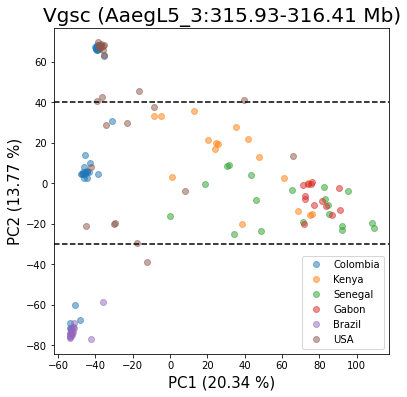

In [18]:
fig, ax = plt.subplots(figsize=(6, 6))

##calculate and plot PCA
allele_counts = allel.AlleleCountsArray(
    gt_chunk.count_alleles())
    
allele_counts_boolean = (allele_counts.max_allele() <= 2) &\
(allele_counts[:, :2].min(axis=1) > 1) & (
    allele_counts.to_frequencies()[:,1] > 0.05)
                         
n_alts = gt_chunk\
.subset(sel0 = allele_counts_boolean).to_n_alt()
    
coords, model = allel.pca(n_alts)

x = coords[:, 0]
y = coords[:, 1]

for country, flt in country_bools.items():
    
    ax.plot(x[flt], y[flt], linestyle = ' ', marker = "o", label=country,
           alpha = 0.5)

ax.set_xlabel(f"PC1 ({round(model.explained_variance_ratio_[0]*100, 2)} %)", 
               fontsize=15)
ax.set_ylabel(f"PC2 ({round(model.explained_variance_ratio_[1]*100, 2)} %)", 
               fontsize=15)

ax.set_title("Vgsc (AaegL5_3:315.93-316.41 Mb)", fontsize=20)

##add lines to indicate the boundaries chosen to separate the clusters
ax.axhline(y=40, color="black", linestyle="--")
ax.axhline(y=-30, color="black", linestyle="--")

ax.legend()

##### identify by cluster in South America

In [19]:
sa_flt = md_filtered["country"].isin(["Brazil", "Colombia"])

print(np.sum(sa_flt))

48


In [20]:
top_cluster = ((y > 40) &\
              md_filtered["country"].isin(["Brazil", "Colombia"]))

middle_cluster = ((y <= 40) &\
                 (y > -30) &\
                (md_filtered["country"].isin(["Brazil", "Colombia"])))

bottom_cluster = ((y < -30) &\
                 (md_filtered["country"].isin(["Brazil", "Colombia"])))

print(np.sum(top_cluster), np.sum(middle_cluster), np.sum(bottom_cluster))

10 16 22


In [21]:
sa_cluster_indices = {}

sa_cluster_indices["top"] = md_filtered[top_cluster].index
sa_cluster_indices["middle"] = md_filtered[middle_cluster].index
sa_cluster_indices["bottom"] = md_filtered[bottom_cluster].index

sa_cluster_indices["bottom"]

Int64Index([ 8, 11, 15, 17, 23, 24, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91,
            92, 93, 94, 95, 96],
           dtype='int64')

##### calculate FST between each cluster in South America in the Vgsc region, by individual variant

In [22]:
fst_dict = {}

for cluster1, cluster2 in itertools.combinations(
    ["top", "middle", "bottom"], 2):
    
    a, b, c = allel.weir_cockerham_fst(region_gt, 
                                   [sa_cluster_indices[cluster1], 
                                    sa_cluster_indices[cluster2]])
    
    fst = (np.sum(a, axis=1) /
           (np.sum(a, axis=1) + np.sum(b, axis=1) + np.sum(c, axis=1)))
    
    fst_dict[(cluster1, cluster2)] = fst

/nas/longleaf/home/rrlove/.conda/envs/rrlove/lib/python3.8/site-packages/allel/stats/fst.py:184: RuntimeWarning: invalid value encountered in true_divide
  p = ac / an[:, np.newaxis, :]
/nas/longleaf/home/rrlove/.conda/envs/rrlove/lib/python3.8/site-packages/allel/stats/fst.py:225: RuntimeWarning: divide by zero encountered in true_divide
  a = ((n_bar / n_C) *
<ipython-input-22-ed40ade3b9c1>:10: RuntimeWarning: invalid value encountered in true_divide
  fst = (np.sum(a, axis=1) /


##### also calculate FST in windows

In [23]:
windowed_fst_dict = defaultdict(dict)

for cluster1, cluster2 in itertools.combinations(
    ["top", "middle", "bottom"], 2):
    
    print(cluster1, cluster2)
    
    fst, windows, counts = \
    allel.windowed_weir_cockerham_fst(
        chroms_dict[chrom]["pos"][region_flt].compute(), region_gt, 
                                          [sa_cluster_indices[cluster1], 
                                           sa_cluster_indices[cluster2]],
                                             size=50000, step=5000)
    
    windowed_fst_dict["50k"][(cluster1, cluster2)] = \
    (fst, windows, counts)
    
    fst, windows, counts = \
    allel.windowed_weir_cockerham_fst(
        chroms_dict[chrom]["pos"][region_flt].compute(),
                                      region_gt, 
                                      [sa_cluster_indices[cluster1], 
                                       sa_cluster_indices[cluster2]],
                                         size=10000, step=1000)
    
    windowed_fst_dict["10k"][(cluster1, cluster2)] = \
    (fst, windows, counts)

top middle


/nas/longleaf/home/rrlove/.conda/envs/rrlove/lib/python3.8/site-packages/allel/stats/fst.py:184: RuntimeWarning: invalid value encountered in true_divide
  p = ac / an[:, np.newaxis, :]
/nas/longleaf/home/rrlove/.conda/envs/rrlove/lib/python3.8/site-packages/allel/stats/fst.py:225: RuntimeWarning: divide by zero encountered in true_divide
  a = ((n_bar / n_C) *
/nas/longleaf/home/rrlove/.conda/envs/rrlove/lib/python3.8/site-packages/allel/stats/fst.py:184: RuntimeWarning: invalid value encountered in true_divide
  p = ac / an[:, np.newaxis, :]
/nas/longleaf/home/rrlove/.conda/envs/rrlove/lib/python3.8/site-packages/allel/stats/fst.py:225: RuntimeWarning: divide by zero encountered in true_divide
  a = ((n_bar / n_C) *
/nas/longleaf/home/rrlove/.conda/envs/rrlove/lib/python3.8/site-packages/allel/stats/fst.py:409: RuntimeWarning: invalid value encountered in double_scalars
  return np.nansum(wa) / (np.nansum(wa) + np.nansum(wb) + np.nansum(wc))


top bottom


/nas/longleaf/home/rrlove/.conda/envs/rrlove/lib/python3.8/site-packages/allel/stats/fst.py:184: RuntimeWarning: invalid value encountered in true_divide
  p = ac / an[:, np.newaxis, :]
/nas/longleaf/home/rrlove/.conda/envs/rrlove/lib/python3.8/site-packages/allel/stats/fst.py:225: RuntimeWarning: divide by zero encountered in true_divide
  a = ((n_bar / n_C) *
/nas/longleaf/home/rrlove/.conda/envs/rrlove/lib/python3.8/site-packages/allel/stats/fst.py:184: RuntimeWarning: invalid value encountered in true_divide
  p = ac / an[:, np.newaxis, :]
/nas/longleaf/home/rrlove/.conda/envs/rrlove/lib/python3.8/site-packages/allel/stats/fst.py:225: RuntimeWarning: divide by zero encountered in true_divide
  a = ((n_bar / n_C) *
/nas/longleaf/home/rrlove/.conda/envs/rrlove/lib/python3.8/site-packages/allel/stats/fst.py:409: RuntimeWarning: invalid value encountered in double_scalars
  return np.nansum(wa) / (np.nansum(wa) + np.nansum(wb) + np.nansum(wc))


middle bottom


/nas/longleaf/home/rrlove/.conda/envs/rrlove/lib/python3.8/site-packages/allel/stats/fst.py:184: RuntimeWarning: invalid value encountered in true_divide
  p = ac / an[:, np.newaxis, :]
/nas/longleaf/home/rrlove/.conda/envs/rrlove/lib/python3.8/site-packages/allel/stats/fst.py:225: RuntimeWarning: divide by zero encountered in true_divide
  a = ((n_bar / n_C) *
/nas/longleaf/home/rrlove/.conda/envs/rrlove/lib/python3.8/site-packages/allel/stats/fst.py:184: RuntimeWarning: invalid value encountered in true_divide
  p = ac / an[:, np.newaxis, :]
/nas/longleaf/home/rrlove/.conda/envs/rrlove/lib/python3.8/site-packages/allel/stats/fst.py:225: RuntimeWarning: divide by zero encountered in true_divide
  a = ((n_bar / n_C) *
/nas/longleaf/home/rrlove/.conda/envs/rrlove/lib/python3.8/site-packages/allel/stats/fst.py:409: RuntimeWarning: invalid value encountered in double_scalars
  return np.nansum(wa) / (np.nansum(wa) + np.nansum(wb) + np.nansum(wc))


##### add the repetitive/non-uniquely-mapping regions

In [24]:
mask_vgsc = mask[((mask["start"] >= 310000000) & (mask["end"] <= 320000000))]

mask_vgsc

,chrom,start,end
1485969,AaegL5_3,310000376,310000527
1485970,AaegL5_3,310000698,310000799
1485971,AaegL5_3,310001002,310001915
1485972,AaegL5_3,310002149,310002167
1485973,AaegL5_3,310002226,310002425
...,...,...,...
1499538,AaegL5_3,319995649,319996389
1499539,AaegL5_3,319996498,319996583
1499540,AaegL5_3,319996873,319996957
1499541,AaegL5_3,319997051,319997132


In [25]:
mask_vgsc["length"] = mask_vgsc["end"] - mask_vgsc["start"]

np.sum(mask_vgsc["length"] >= 100)

<ipython-input-25-c41b8c546dd4>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mask_vgsc["length"] = mask_vgsc["end"] - mask_vgsc["start"]


9345

In [26]:
mask_vgsc_trimmed = mask_vgsc[mask_vgsc["length"] >= 100]

mask_vgsc_trimmed

,chrom,start,end,length
1485969,AaegL5_3,310000376,310000527,151
1485970,AaegL5_3,310000698,310000799,101
1485971,AaegL5_3,310001002,310001915,913
1485973,AaegL5_3,310002226,310002425,199
1485974,AaegL5_3,310002441,310002631,190
...,...,...,...,...
1499530,AaegL5_3,319993260,319993698,438
1499532,AaegL5_3,319993826,319994071,245
1499533,AaegL5_3,319994073,319994211,138
1499538,AaegL5_3,319995649,319996389,740


In [27]:
mask_vgsc_base = (map_masks["AaegL5_3"][309999999:320000000] &\
 repeat_masks["AaegL5_3"][309999999:320000000]).compute()

mask_vgsc_base

array([ True,  True,  True, ..., False, False, False])

In [28]:
vgsc_bases = allel.SortedIndex(np.arange(310000000, 320000001, 1))

vgsc_bases

0,1,2,3,4,...,9999996,9999997,9999998,9999999,10000000
310000000,310000001,310000002,310000003,310000004,...,319999996,319999997,319999998,319999999,320000000


In [29]:
accessible, accessible_windows, accessible_counts =\
allel.windowed_statistic(vgsc_bases, mask_vgsc_base, np.mean, 
                         size=10000, step=1000)

accessible

array([0.5057    , 0.431     , 0.4758    , ..., 0.3846    , 0.3751    ,
       0.39766023])

##### read in the gff3

In [30]:
gff3 = pd.read_table("/overflow/dschridelab/users/rrlove/aedes/refs/aegy/VectorBase-54_AaegyptiLVP_AGWG.gff",
                     sep="\t", comment="#", header=None)

gff3.columns = ["seqid", "source", "type", "start", "end", "score", "strand",
               "phase", "attributes"]

gff3["name"] = gff3["attributes"].str.split(";", expand=True)[0].str.lstrip("ID=")

exons = gff3[((gff3["attributes"].str.contains("AAEL023266")) &\
              (gff3["type"] == "exon"))]

exons.head()

,seqid,source,type,start,end,score,strand,phase,attributes,name
211177,AaegL5_3,VEuPathDB,exon,315926360,315931874,.,-,.,ID=exon_AAEL023266-RA-E37;Parent=AAEL023266-RA...,exon_AAEL023266-RA-E37
211178,AaegL5_3,VEuPathDB,exon,315931941,315932245,.,-,.,ID=exon_AAEL023266-RA-E36;Parent=AAEL023266-RA...,exon_AAEL023266-RA-E36
211179,AaegL5_3,VEuPathDB,exon,315938708,315938978,.,-,.,ID=exon_AAEL023266-RA-E35;Parent=AAEL023266-RA...,exon_AAEL023266-RA-E35
211180,AaegL5_3,VEuPathDB,exon,315939046,315939291,.,-,.,ID=exon_AAEL023266-RA-E34;Parent=AAEL023266-RA...,exon_AAEL023266-RA-E34
211181,AaegL5_3,VEuPathDB,exon,315939361,315939555,.,-,.,ID=exon_AAEL023266-RA-E33;Parent=AAEL023266-RA...,exon_AAEL023266-RA-E33


In [31]:
#region_vgsc_flt = ((chroms_dict[chrom]["pos"][region_flt] > 315926360) &\
# (chroms_dict[chrom]["pos"][region_flt] < 316405639)).compute()

#len(region_vgsc_flt), np.sum(region_vgsc_flt)

In [32]:
outString = ingenos.make_date_stamp(
    results_path + "Vssc/Vgsc_haplotype_FST_includes_SNPs", ".pdf")

outString

'/overflow/dschridelab/users/rrlove/aedes/results/Vssc/Vgsc_haplotype_FST_includes_SNPs.021023.pdf'

In [33]:
cmap = plt.get_cmap("tab10")

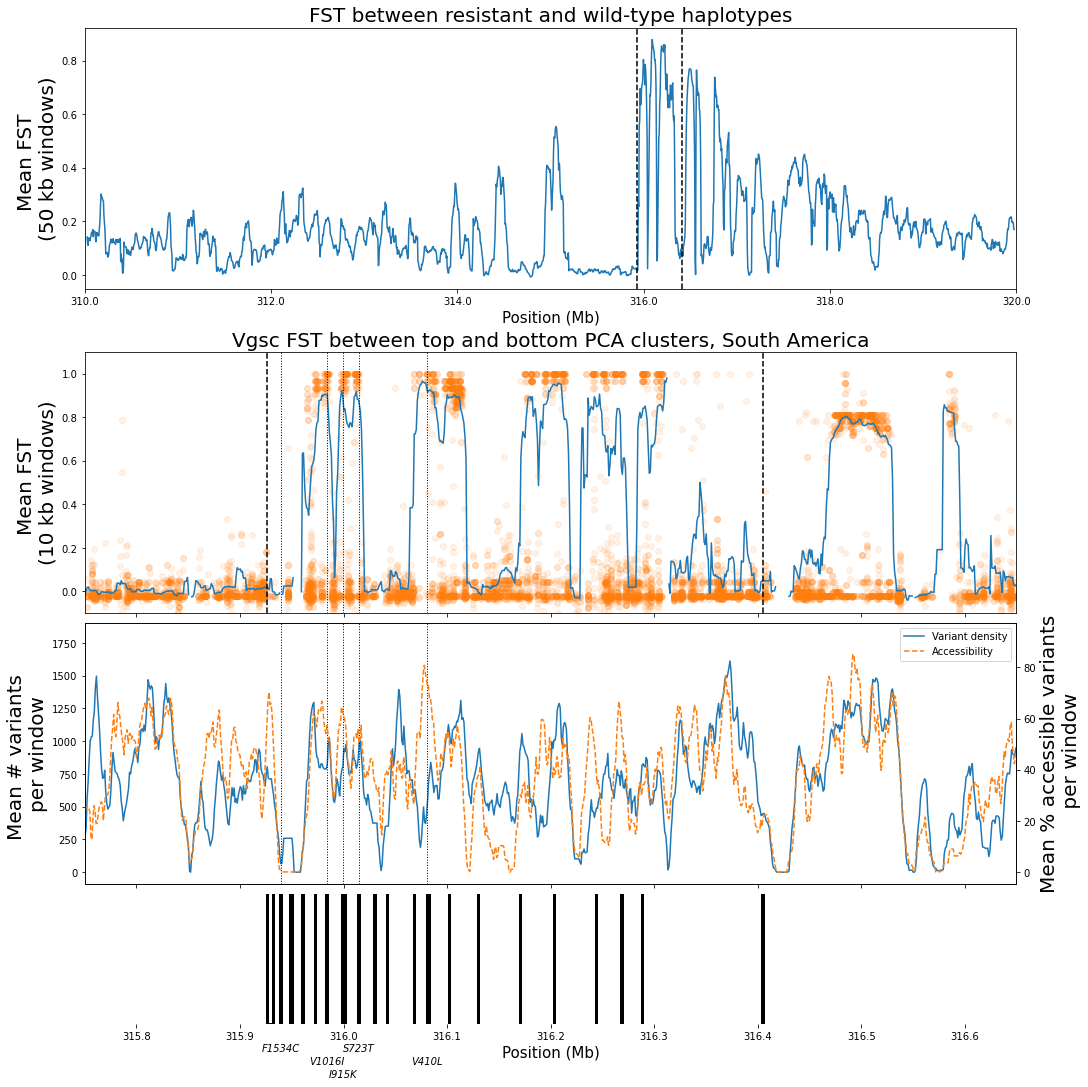

In [34]:
fig = plt.figure(figsize=(15, 15), constrained_layout=True)

gs = GridSpec(7, 1, figure=fig)

##plot FST of the larger region
ax1 = fig.add_subplot(gs[:2, 0])

(fst, windows, counts) = windowed_fst_dict["50k"][("top", "bottom")]

ax1.plot(np.mean(windows, axis=1), fst)
        
ax1.axvline(x = 315926360, linestyle = "--", color = "black")
ax1.axvline(x = 316405639, linestyle = "--", color = "black")
    
ax1.set_xlim([310000000, 320000000])
ax1.set_xlabel("Position (Mb)", fontsize=15)
ax1.ticklabel_format(style='plain')
ax1.xaxis.set_major_formatter(yfmt)
ax1.set_ylabel("Mean FST \n(50 kb windows)", fontsize=20)

ax1.set_title("FST between resistant and wild-type haplotypes", 
             fontsize=20)

##show the positions of all FST variants
ax2 = fig.add_subplot(gs[2:4, 0])

fst = fst_dict[("top", "bottom")]

ax2.plot(region_pos, fst, marker="o", alpha=0.1,
            linestyle=" ", color = cmap(1))

ax2.set_title("Vgsc FST between top and bottom PCA clusters, South America",
             fontsize=20)

ax2.set_ylim([-.1,1.1])

##add windowed FST
(fst, windows, counts) = windowed_fst_dict["10k"][('top', 'bottom')]
ax2.plot(np.mean(windows, axis=1), fst, label="top vs. bottom cluster")
        
ax2.axvline(x = 315926360, linestyle = "--", color = "black")
ax2.axvline(x = 316405639, linestyle = "--", color = "black")

ax2.set_xlim([315750000, 316650000])
    
ax2.set_ylabel("Mean FST \n(10 kb windows)", fontsize=20)

##plot variant density and repetitive/non-uniquely-mapping regions
ax3 = fig.add_subplot(gs[4:6, 0], sharex=ax2)
ax3.plot(np.mean(windows, axis=1), counts, label="Variant density")
ax3.set_ylabel("Mean # variants \nper window", fontsize=20)

ax3_dup = ax3.twinx()

ax3_dup.plot(np.mean(accessible_windows, axis=1), accessible * 100, linestyle="--",
         color=cmap(1), label = "Accessibility")
ax3_dup.set_ylabel("Mean % accessible variants\n per window", fontsize=20)

##from https://stackoverflow.com/questions/33611803/pyplot-single-legend-when-plotting-on-secondary-y-axis
handles,labels = [],[]
for ax in [ax3, ax3_dup]:
    for handle, label in zip(*ax.get_legend_handles_labels()):
        handles.append(handle)
        labels.append(label)

ax3_dup.legend(handles,labels)
    
##add the exons
ax4 = fig.add_subplot(gs[6, 0], sharex=ax2)

for i, row in exons.iterrows():
    
    exon_length = row["end"] - row["start"]
    
    rect = patches.Rectangle((row["start"], 0), exon_length, 10, linewidth=3,
                            edgecolor = "black", facecolor = "none")
    
    ax4.add_patch(rect)
    
##add focal SNPs

##F1534C, V1016I, I915K, S723T, V410L
trans = transforms.blended_transform_factory(ax4.transData, ax4.transAxes)

for snp, label, y_place in zip([315939224, 315983763, 315999297, 316014588, 316080722],
                               ["F1534C", "V1016I", "I915K", "S723T", "V410L"],
                               [-.21, -.31, -.41, -.21, -.31]):
    
    ax2.axvline(x=snp, color="black", linestyle="dotted", linewidth=1)
    ax3.axvline(x=snp, color="black", linestyle="dotted", linewidth=1)
    ax4.axvline(x=snp, color="black", linestyle="dotted", linewidth=1)
    ax4.text(x=snp, y=y_place, s=label, fontstyle="italic", ha="center", transform=trans)
    
##formatting  
for ax in [ax2, ax3, ax3_dup]:
    ax.tick_params(labelbottom=False)
    
ax4.set_xlabel("Position (Mb)", fontsize=15)
ax4.ticklabel_format(style='plain')
ax4.xaxis.set_major_formatter(yfmt)

ax4.get_yaxis().set_visible(False)
for spine in ax4.spines.values():
    
    spine.set_visible(False)

#plt.savefig(outString, bbox_inches="tight")